In [1236]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

In [1237]:
antenna_poplulation = 3
tags_location = np.array([-2, 4])
tag_population = tags_location.shape[0]
y_distance = 6
sample_count = 1000
frequency = 920.4e6
antenna_space = 0.25
transmission_power = 37.5
light_speed = 2.998e8
wave_length = light_speed / frequency
angular_velocity = 2 * np.pi * frequency
theta_range = np.arange(-90, 90.001, 0.001)

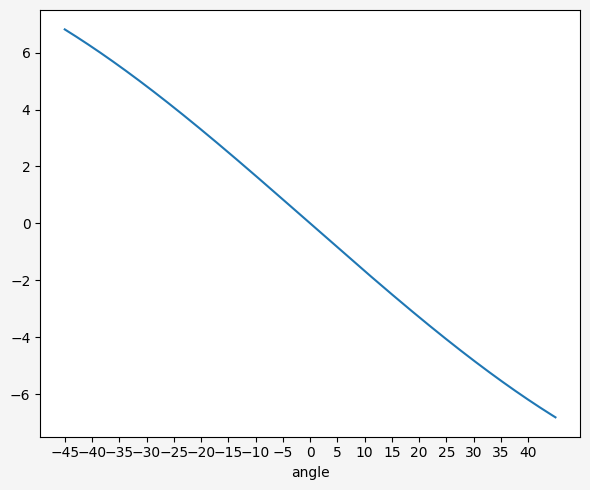

In [1238]:
tag_angles = np.radians(np.arange(-45, 45.001, 0.001))
phase1 = actual_phase = np.array(
    (
        2 * angular_velocity / light_speed
        * (
            y_distance / np.abs(np.cos(tag_angles)) 
        )
    )
    # % (2 * np.pi)
)

phase2 = actual_phase = np.array(
    (
        2 * angular_velocity / light_speed
        * (
            y_distance / np.abs(np.cos(tag_angles)) - antenna_space * np.sin(tag_angles)
        )
    )
    # % (2 * np.pi)
)

phase_diff = phase2-phase1


fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=6, h=5)
x = np.arange(-45, 45.001, 0.001)
ax.plot(x, phase_diff)
ax.set_xticks(np.arange(-45, 45, step=5))
ax.set_xlabel("angle")
# ax.legend()
plt.show()

### Generate Sample data

In [1239]:
"""
In mock data, the phase data seem to be corrected by the wave which transmited first
in each period for making it easier to analysis.
-> s(t) can be constant value of transmission_power
"""

# tag_location[m] is distance between tag and y-axis
tag_angles = np.arctan(tags_location / y_distance)
print(tag_angles * 180 / np.pi)

phase_samples = [np.array(
    [
        (
            angular_velocity / light_speed
            * (
                y_distance / np.abs(np.cos(tag_angles)) - (antenna - 1) * antenna_space * np.sin(tag_angles)
            )
        ) 
        # % (2 * np.pi)
        + np.random.normal(loc=0, scale=1 / 6, size=tag_population)
        for antenna in range(1, antenna_poplulation + 1)
    ]
).T for i in range(sample_count)]

print(phase_samples[0])


# phase_samples = np.array(
#     [
#         (
#             actual_phase
#             + np.array(
#                 [
#                     np.random.normal(loc=0, scale=1 / 6, size=tag_population)
#                     for antenna in range(antenna_poplulation)
#                 ]
#             )
#         ).T
#         for i in range(sample_count)
#     ]
# )

columns = ["samplingNumber", "tagNumber", "frequency"]
columns.extend([f"antenna{i+1}.phase" for i in range(antenna_poplulation)])

df = pd.DataFrame(columns=columns)

for i in range(sample_count):
    new_data = pd.DataFrame(data=phase_samples[i])
    new_data["samplingNumber"] = i
    new_data["tagNumber"] = [i+1 for i in range(tag_population)]
    new_data["frequency"] = frequency
    for antenna in range(antenna_poplulation):
        new_data = new_data.rename(columns={antenna: f"antenna{antenna+1}.phase"})
    df = pd.concat([df, new_data])

[-18.43494882  33.69006753]
[[121.99060219 123.66670565 125.22499912]
 [139.10256577 136.19865305 133.79597273]]


## MUSIC Method

In [1240]:
from classes.music import MUSIC

music = MUSIC(antenna_poplulation=antenna_poplulation, tag_population=tag_population, sampling_count=sample_count, antenna_space=antenna_space, wave_length=wave_length, tx_power=transmission_power, theta_range=theta_range)
music_spectrum = music.get_music_spectrum(data=df)
estimated_angles = music.peak_search(music_spectrum=music_spectrum)
print(estimated_angles)

[-80.67  -48.29  -33.807 -18.43   18.43   33.807  48.29   80.67 ]


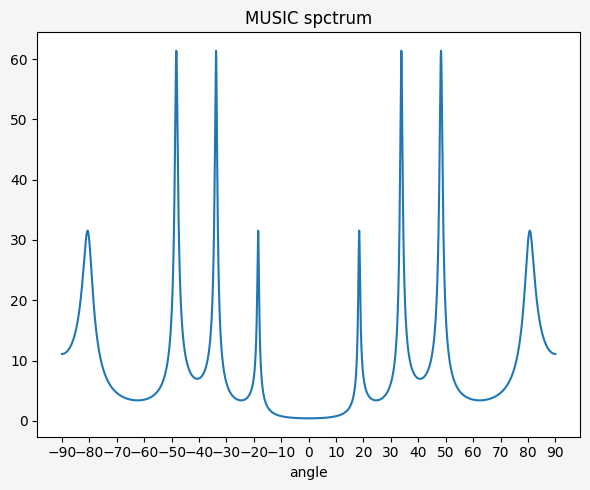

In [1241]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=6, h=5)
x = theta_range
ax.plot(x, music_spectrum)
ax.set_xticks(np.arange(-90, 95, step=10))
ax.set_title("MUSIC spctrum")
ax.set_xlabel("angle")
plt.show()